In [ ]:
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.9/316.9 MB 4.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.0-py2.py3-none-any.whl size=317425344 sha256=abb78a7cef88a4788ee96254f1f69d182cc9b27de01810f3fce7cf9a694560a0
  Stored in directory: /root/.cache/pip/wheels/41/4e/10/c2cf2467f71c678cfc8a6b9ac9241e5e44a01940da8fbb17fc
Successfully built pyspark


In [ ]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import Tokenizer, StopWordsRemover, CountVectorizer
from pyspark.ml.classification import LogisticRegression, NaiveBayes, RandomForestClassifier
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, TrainValidationSplit
from pyspark.sql.functions import udf
from pyspark.sql.types import IntegerType
from pyspark.sql.functions import col
from pyspark.ml.feature import StringIndexer
from pyspark.sql.functions import regexp_replace

In [ ]:
spark = SparkSession.builder.appName("SentimentAnalysis").getOrCreate()

The given dataset is sentiment

In [ ]:
df = spark.read.csv("/content/sentiment_tweets3.csv",header=True,inferSchema=True)
df.show()

+-----+--------------------+-------------------------+
|Index|  message to examine|label (depression result)|
+-----+--------------------+-------------------------+
|  106|just had a real g...|                        0|
|  217|is reading manga ...|                        0|
|  220|@comeagainjen htt...|                        0|
|  288|@lapcat Need to s...|                        0|
|  540|ADD ME ON MYSPACE...|                        0|
|  624|so sleepy. good t...|                        0|
|  701|@SilkCharm re: #n...|                        0|
|  808|23 or 24ï¿½C poss...|                        0|
| 1193|nite twitterville...|                        0|
| 1324|@daNanner Night, ...|                        0|
| 1332|Good morning ever...|                        0|
| 1368|Finally! I just c...|                        0|
| 1578|kisha they cnt ge...|                        0|
| 1595|@nicolerichie Yes...|                        0|
| 1861|I really love ref...|                        0|
| 1889|@bl

Data Preprocessing

In [ ]:
df = df.drop("Index")
df.show()

+--------------------+-------------------------+
|  message to examine|label (depression result)|
+--------------------+-------------------------+
|just had a real g...|                        0|
|is reading manga ...|                        0|
|@comeagainjen htt...|                        0|
|@lapcat Need to s...|                        0|
|ADD ME ON MYSPACE...|                        0|
|so sleepy. good t...|                        0|
|@SilkCharm re: #n...|                        0|
|23 or 24ï¿½C poss...|                        0|
|nite twitterville...|                        0|
|@daNanner Night, ...|                        0|
|Good morning ever...|                        0|
|Finally! I just c...|                        0|
|kisha they cnt ge...|                        0|
|@nicolerichie Yes...|                        0|
|I really love ref...|                        0|
|@blueaero ooo it'...|                        0|
|@rokchic28 no pro...|                        0|
|@shipovalov &quot..

In [ ]:
df.schema

StructType([StructField('message to examine', StringType(), True), StructField('label (depression result)', StringType(), True)])

In [ ]:
df = df.withColumn("text_cleaned", regexp_replace("message to examine", "[^a-zA-Z0-9 ]", ""))
df.show(truncate=False)

+---------------------------------------------------------------------------------------------------------------------------------------+-------------------------+-------------------------------------------------------------------------------------------------------------------------------+
|message to examine                                                                                                                     |label (depression result)|text_cleaned                                                                                                                   |
+---------------------------------------------------------------------------------------------------------------------------------------+-------------------------+-------------------------------------------------------------------------------------------------------------------------------+
|just had a real good moment. i missssssssss him so much,                                                                   

In [ ]:
tokenizer = Tokenizer(inputCol="text_cleaned", outputCol="words")
remover = StopWordsRemover(inputCol="words", outputCol="filtered_words")
vectorizer = CountVectorizer(inputCol="filtered_words", outputCol="features")

In [ ]:
pipeline = Pipeline(stages=[tokenizer, remover, vectorizer])
model = pipeline.fit(df)
data = model.transform(df)

In [ ]:
data.show()

+--------------------+-------------------------+--------------------+--------------------+--------------------+--------------------+
|  message to examine|label (depression result)|        text_cleaned|               words|      filtered_words|            features|
+--------------------+-------------------------+--------------------+--------------------+--------------------+--------------------+
|just had a real g...|                        0|just had a real g...|[just, had, a, re...|[real, good, mome...|(23437,[3,27,112,...|
|is reading manga ...|                        0|is reading manga ...|[is, reading, man...|[reading, manga, ...|(23437,[0,393,141...|
|@comeagainjen htt...|                        0|comeagainjen http...|[comeagainjen, ht...|[comeagainjen, ht...|(23437,[0,3322,66...|
|@lapcat Need to s...|                        0|lapcat Need to se...|[lapcat, need, to...|[lapcat, need, se...|(23437,[43,65,71,...|
|ADD ME ON MYSPACE...|                        0|ADD ME ON MYSPACE...|

In [ ]:
from pyspark.ml.feature import StringIndexer

In [ ]:
indexer = StringIndexer(inputCol="label (depression result)", outputCol="label")
data = indexer.fit(data).transform(data)
data=data.drop("label (depression result)")
data.show()

+--------------------+--------------------+--------------------+--------------------+--------------------+-----+
|  message to examine|        text_cleaned|               words|      filtered_words|            features|label|
+--------------------+--------------------+--------------------+--------------------+--------------------+-----+
|just had a real g...|just had a real g...|[just, had, a, re...|[real, good, mome...|(23437,[3,27,112,...|  0.0|
|is reading manga ...|is reading manga ...|[is, reading, man...|[reading, manga, ...|(23437,[0,393,141...|  0.0|
|@comeagainjen htt...|comeagainjen http...|[comeagainjen, ht...|[comeagainjen, ht...|(23437,[0,3322,66...|  0.0|
|@lapcat Need to s...|lapcat Need to se...|[lapcat, need, to...|[lapcat, need, se...|(23437,[43,65,71,...|  0.0|
|ADD ME ON MYSPACE...|ADD ME ON MYSPACE...|[add, me, on, mys...|[add, myspace, , ...|(23437,[0,315,594...|  0.0|
|so sleepy. good t...|so sleepy good ti...|[so, sleepy, good...|[sleepy, good, ti...|(23437,[3,9

Applying ML model for the given dataset

In [ ]:
train_data, test_data = data.randomSplit([0.8, 0.2], seed=123)

Applying Naive Baeyes algorithm

In [ ]:
nb = NaiveBayes()
sentiment_analyzer = nb.fit(train_data)

In [ ]:
predictions = sentiment_analyzer.transform(test_data)
predictions.show()

+--------------------+--------------------+--------------------+--------------------+--------------------+-----+--------------------+--------------------+----------+
|  message to examine|        text_cleaned|               words|      filtered_words|            features|label|       rawPrediction|         probability|prediction|
+--------------------+--------------------+--------------------+--------------------+--------------------+-----+--------------------+--------------------+----------+
| I'm happy and co...| Im happy and con...|[, im, happy, and...|[, im, happy, con...|(23437,[0,2,29,85...|  0.0|[-24.131446298922...|[0.92811315904895...|       0.0|
| Stray Cats ~ Str...| Stray Cats  Stra...|[, stray, cats, ,...|[, stray, cats, ,...|(23437,[0,795,131...|  0.0|[-73.477773281516...|[0.72289166139073...|       0.0|
| http://www.zav.c...| httpwwwzavczzave...|[, httpwwwzavczza...|[, httpwwwzavczza...|(23437,[0,1,3,5,8...|  1.0|[-225.04244304370...|[0.18391010023833...|       1.0|
| ht

Comparison of accuracy of ML models such as Logistic Regression, Naive Bayes and Random Forest Classifier for the given dataset

In [ ]:
from pyspark.ml.classification import LogisticRegression, NaiveBayes, RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

models = [LogisticRegression(), NaiveBayes(), RandomForestClassifier()]
l=[]
for model in models:
    model_name = model.__class__.__name__
    print(f"Training {model_name}...")
    model_fit = model.fit(train_data)
    predictions = model_fit.transform(test_data)
    evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
    accuracy = evaluator.evaluate(predictions)
    print(f"Accuracy for {model_name}: {accuracy}")
    l.append(accuracy)

Training LogisticRegression...
Accuracy for LogisticRegression: 0.9608404966571156
Training NaiveBayes...
Accuracy for NaiveBayes: 0.9656160458452722
Training RandomForestClassifier...
Accuracy for RandomForestClassifier: 0.7722063037249284


In [ ]:
lr = LogisticRegression()
nb = NaiveBayes()
rf = RandomForestClassifier()

In [ ]:
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")

Hyper parameter tuning for logistic regression

In [ ]:
lr_param_grid = (ParamGridBuilder()
    .addGrid(lr.maxIter, [10, 50, 100])
    .addGrid(lr.regParam, [0.01, 0.1, 0.2])
    .build())

In [ ]:
tvs1 = TrainValidationSplit(estimator=lr, evaluator=evaluator, estimatorParamMaps=lr_param_grid, trainRatio=0.8)

In [ ]:
tvs1_model1 = tvs1.fit(train_data)
best_model = tvs1_model1.bestModel

In [ ]:
best_predictions = best_model.transform(test_data)
best_accuracy = evaluator.evaluate(best_predictions)
print(f"Best Model Accuracy: {best_accuracy}")

Best Model Accuracy: 0.9708691499522445


Hyper parameter tuning for Naive baeyes algorithm

In [ ]:
nb_param_grid = (ParamGridBuilder()
    .addGrid(nb.smoothing, [0.1, 0.01, 0.001])
    .build())

In [ ]:
tvs2 = TrainValidationSplit(
    estimator=nb,
    estimatorParamMaps=nb_param_grid,
    evaluator=evaluator,
    trainRatio=0.8)

In [ ]:
tvs2_model = tvs2.fit(train_data)

In [ ]:
best_nb_model = tvs2_model.bestModel
best_nb_predictions = best_nb_model.transform(test_data)
best_nb_accuracy = evaluator.evaluate(best_nb_predictions)
print(f"Best Naive Bayes Model Accuracy: {best_nb_accuracy}")

Best Naive Bayes Model Accuracy: 0.9159503342884432


In [ ]:
param_grid = (ParamGridBuilder()
    .addGrid(rf.maxDepth, [5, 10, 15])
    .addGrid(rf.numTrees, [10, 20, 30])
    .addGrid(rf.featureSubsetStrategy, ['auto', 'sqrt', 'log2'])
    .build())

In [ ]:
tvs3 = TrainValidationSplit(
    estimator=rf,
    estimatorParamMaps=param_grid,
    evaluator=evaluator,
    trainRatio=0.8)

In [ ]:
tvs3_model = tvs3.fit(train_data)

In [ ]:
best_rf_model = tvs3_model.bestModel
best_rf_predictions = best_rf_model.transform(test_data)
best_rf_accuracy = evaluator.evaluate(best_rf_predictions)
print(f"Best Random Forest Model Accuracy: {best_rf_accuracy}")

Best Random Forest Model Accuracy: 0.7817574021012417


In [ ]:
import matplotlib.pyplot as plt

ACCURACY AFTER HYPER PARAMETER TUNING : 



<BarContainer object of 3 artists>

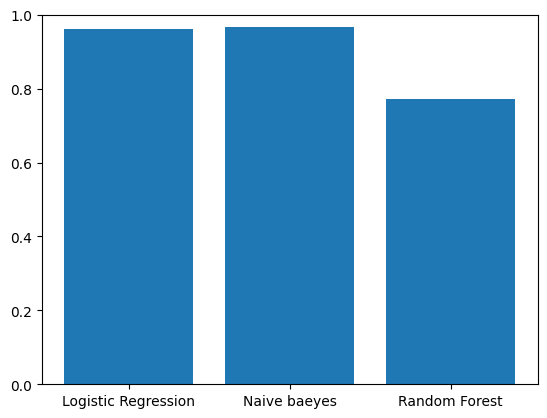

In [ ]:
models = ['Logistic Regression','Naive baeyes','Random Forest']
print('ACCURACY BEFORE HYPER PARAMETER TUNING : \n')
plt.ylim(0,1.0)
plt.bar(models,l)

ACCURACY AFTER HYPER PARAMETER TUNING : 



<BarContainer object of 3 artists>

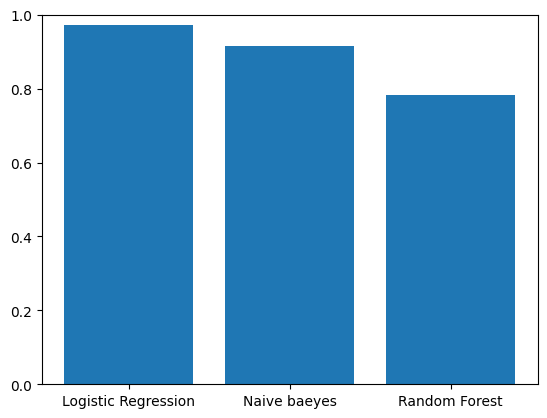

In [ ]:
acc = [best_accuracy,best_nb_accuracy,best_rf_accuracy]
models = ['Logistic Regression','Naive baeyes','Random Forest']
print('ACCURACY AFTER HYPER PARAMETER TUNING : \n')
plt.ylim(0,1.0)
plt.bar(models,acc)